# 🚀 Snorkel Ludwig Tutorial: Spam Classification

In this tutorial, we will demonstrate how Snorkel labels can be easily integrated with [Ludwig](https://uber.github.io/ludwig), a simple, code-free interface for training deep machine learning models.  This package allows for out-of-the-box experimentation with different neural network architectures -- even for datapoints with many modalities! -- via a simple command line interface.

We'll start with our spam detection task from the [Spam tutorial](https://snorkel.org/use-cases/spam-tutorial).  If you have not yet done so, please run through this tutorial -- which generates the training data for the spam classification task we will use in this tutorial -- and execute the very last cell.  Once complete, you should see three `.csv` files appear in the `./data/spam` subdirectory in this folder. 

As a quick reminder, the spam detection task is as follows:

### Task: Spam Detection

We use a [YouTube comments dataset](http://www.dt.fee.unicamp.br/~tiago//youtubespamcollection/) that consists of YouTube comments from 5 videos. The task is to classify each comment as being

* **`HAM`**: comments relevant to the video (even very simple ones), or
* **`SPAM`**: irrelevant (often trying to advertise something) or inappropriate messages

For example, the following comments are `SPAM`:

        "Subscribe to me for free Android games, apps.."

        "Please check out my vidios"

        "Subscribe to me and I'll subscribe back!!!"

and these are `HAM`:

        "3:46 so cute!"

        "This looks so fun and it's a good song"

        "This is a weird video."

## 1. Loading Training Data

Our first task is to load up the training, validation, and testing data we saved in Ludwig's native `.csv` format at the end of the spam tutorial:

In [1]:
import pandas as pd

DISPLAY_ALL_TEXT = False

pd.set_option("display.max_colwidth", 0 if DISPLAY_ALL_TEXT else 50)

df_train_filtered = pd.read_csv('data/spam/spam_train.csv')
df_dev = pd.read_csv('data/spam/spam_dev.csv')
df_test = pd.read_csv('data/spam/spam_test.csv')

In [2]:
df_train_filtered.head(5)

,Unnamed: 0,author,date,text,label,video,probs
0,0,Alessandro leite,2014-11-05T22:21:36,pls http://www10.vakinha.com.br/VaquinhaE.aspx...,-1.0,1,0.49813575 0.50186425
1,1,Salim Tayara,2014-11-02T14:33:30,"if your like drones, plz subscribe to Kamal Ta...",-1.0,1,0.03963982 0.96036018
2,5,Giang Nguyen,2014-11-06T04:55:41,https://www.facebook.com/teeLaLaLa﻿,-1.0,1,0.79333257 0.20666743
3,11,Praise Samuel,2014-11-08T11:10:30,2 billion views wow not even baby by justin be...,-1.0,1,0.65369614 0.34630386
4,12,Malin Linford,2014-11-05T01:13:43,Hey guys please check out my new Google+ page ...,-1.0,1,0.00792694 0.99207306


Notice that the dataframe containing our training set contains a column called `probs`, which we added in the very last cell of the spam tutorial.  This field contains the probabilistic label vector generated by the Snorkel label model as a space-separated list of float values, which aligns with the convention for the Ludwig [`vector features`](https://uber.github.io/ludwig/user_guide/#vector-features) we'll need to use to handle probabilistic labels.  Note that in our development and test sets, we have recorded the true label in this column using a one-hot encoding, with a value of 1 at the index of the true label and 0 otherwise.

## 2. Training a Code-Free Deep Learning Classifier with Ludwig

We'll now use the noisy training labels we generated with Snorkel to train a neural network classifier for our task.  Notice that when we use this sort of model, we do not need to explicitly featurize the data!

First, we'll suppress some verbose outputs and check to see if our Tensorflow installation recognizes an installed, CUDA-enabled GPU.  This is not necessary, but can decrease training time in practical settings by orders of magnitude

In [8]:
# This cell suppresses some verbose warnings -- you can ignore it
import warnings

warnings.filterwarnings("ignore")

In [9]:
# This cell checks to see if you have tensorflow-gpu & CUDA installed,
# and also have a GPU available; if so, it will print `GPU Available? True`

import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf

gpu = tf.test.is_gpu_available()
print(f"GPU Available? {gpu}")

GPU Available? False


To define the type of model we wish to train in Ludwig, we provide a [`model defintion`](https://uber.github.io/ludwig/user_guide/#command-line-interface) file that will contain all required information for building and training the model.  We use this interface to create our model definition [file](ludwig/model/spam_model_definition.yaml), which is a relatively straightforward `.yaml` file defining a single-layer, bidirectional Long Short-Term Memory (LSTM) network, a common tool for text analysis.  We've loaded this `.yaml` file up below as a dictionary so you can see what it contains -- if you'd like to see what the actual file looks like, open up `model/spam_model_definition.yaml` in a text editor.  

The main points to take away from this are:

* Input Features: defines the type of input (`text`), the type of neural network to use (`lstm`), and the network architecture parametres (e.g. `embedding_size`)
* Output Features: defines the type of problem that will be solved, the type of loss function to use, and the parameters of the last neural network layer
* Training: defines training hyperparameters and scheduling

Note that the `name` field of each feature corresponds to a column in the `.csv` files that contains the relevant data.

More examples of and information about how to build model definition files can be found in the [Ludwig User Guide](https://uber.github.io/ludwig/examples/).

In [28]:
import yaml
with open('model/spam_model_definition.yaml') as fl:
    a = yaml.load(fl)

{'input_features': [{'name': 'text',
   'type': 'text',
   'level': 'word',
   'encoder': 'rnn',
   'cell_type': 'lstm',
   'bidirectional': True,
   'num_layers': 1,
   'embedding_size': 16,
   'state_size': 64,
   'reduce_output': 'last',
   'preprocessing': {'word_format': 'space'}}],
 'output_features': [{'name': 'probs',
   'type': 'vector',
   'softmax': True,
   'num_fc_layers': 1,
   'fc_size': 64,
   'loss': {'type': 'softmax_cross_entropy',
    'confidence_penalty': 0,
    'robust_lambda': 0,
    'class_weights': 1,
    'class_similarities': None,
    'class_similarities_temperature': 0,
    'labels_smoothing': 0,
    'negative_samples': 0,
    'sampler': None,
    'distortion': 1,
    'unique': False}}],
 'training': {'epochs': 25,
  'learning_rate': 0.01,
  'reduce_learning_rate_on_plateau': 5,
  'reduce_learning_rate_on_plateau_patience': 2,
  'reduce_learning_rate_on_plateau_rate': 0.5,
  'validation_measure': 'loss',
  'regularization_lambda': 0.0005}}

At this point, we have our `.csv` files for training and our `.yaml` file for model definition.  This is all we need to train a deep learning model in Ludwig, we can now just work just from the command line! 

In `jupyter`, system commands can be provided using the `!`, so we'll use this for convenience.  Once we've written the model definition file, all we have to do to train a model (using a GPU if available), evaluate that model, and log all results in a consistent format using Ludwig is to run the command below. Note that all that is reuqired are the paths to the training, development, and test sets; the path to the model definition file; and the name of the experiment.

In [29]:
!ludwig experiment \
  --data_train_csv data/spam/spam_train.csv \
  --data_validation_csv data/spam/spam_dev.csv \
  --data_test_csv data/spam/spam_test.csv \
  --model_definition_file model/spam_model_definition.yaml \
  --output_directory results/spam_experiment_run \
  --experiment_name trial_1

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

███████████████████████
█ █ █ █  ▜█ █ █ █ █   █
█ █ █ █ █ █ █ █ █ █ ███
█ █   █ █ █ █ █ █ █ ▌ █
█ █████ █ █ █ █ █ █ █ █
█     █  ▟█     █ █   █
███████████████████████
ludwig v0.2.1 - Experiment

Experiment name: trial_1
Model name: run
Output path: results/spam_experiment_run/trial_1_run_0


ludwig_version: '0.2.1'
command: ('/home/jdunnmon/repos/anaconda3/envs/snorkel/bin/ludwig experiment '
 '--data_train_csv data/spam/spam_train.csv --data_validation_csv '
 'data/spam/spam_dev.csv --data_test_csv data/spam/spam_test.csv '
 '--model_definition_file model/spam_model_definition.yaml --output_directory '
 'results/spam_experimen

## 3. Visualize Model Results

We can also use tools in Ludwig to visualize the training curves from the model run logs -- just load up the `.json` file with the training statistics, and run a quick visualization function as below.  Note that the validation and training loss track each other, indicating that this model likely has not overfit.  The accessibility of such common diagnostics is an advantage of focusing on model supervision, and letting modern deep learning software handle the model training procedures.

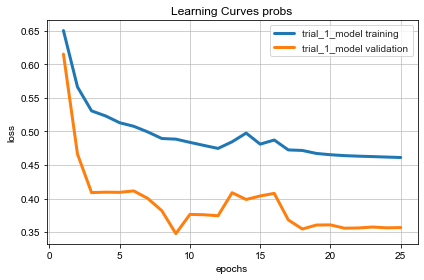

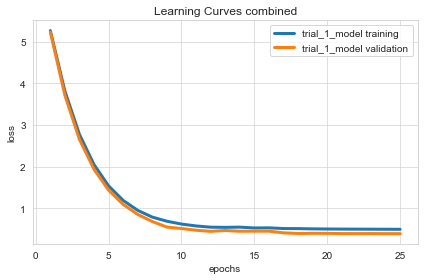

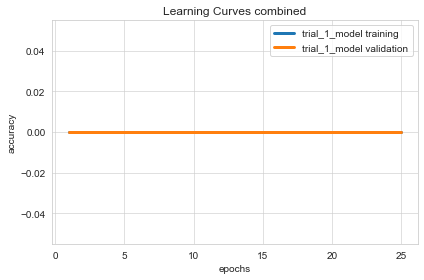

In [16]:
import json

# Opening log file from experiment
with open(f"results/spam_experiment_run/trial_1_run/training_statistics.json") as f:
    train_stats = json.load(f)

# USing ludwig to visualize the training curves
from ludwig.visualize import learning_curves

a = learning_curves(
    train_stats,
    "SPAM",
    model_names="trial_1_model",
    output_directory=None,
    file_format="pdf",
)

Finally, as before, we confirm that we've learned a useful spam classifier -- but this time, we didn't even need to featurize the data!

In [19]:
import numpy as np

# Loading probabilistic labels
ludwig_probs_test = np.load("results/spam_experiment_run/trial_1_run/probs_predictions.npy")
# Evaluating model with a cutoff of 0.5
ludwig_preds_test = ludwig_probs_test[:, 1] > 0.5
# Getting ground truth labels
Y_test = df_test.label.values

# Computing and printing test set accuracy
accuracy_test = np.mean(ludwig_preds_test == Y_test)
print(f"Ludwig Test Accuracy: {accuracy_test* 100:.1f}%")

Ludwig Test Accuracy: 88.4%


## Summary

In this tutorial, we accomplished the following:

* We showed how programmatic Snorkel labels can be easily integrated into modern, code-free deep learning frameworks like [Ludwig](https://uber.github.io/ludwig)
* We demonstrated how Ludwig's inbuilt tools can be used to visualize training performance

Note that while we have mostly used Snorkel's labeling utility in this tutorial, the workflow using the data augmentation package would look no different; as long as the data is saved in the correct `.csv` format, Ludwig can interact with it seamlessly.

### Next Steps

If you enjoyed this tutorial and want to learn more, check out the following:

* Using Snorkel + text to supervise an image model via [cross-modal weak supervision](https://snorkel.org/use-cases/visual-relation-tutorial)
* Using [data augmentation](https://snorkel.org/use-cases/02-spam-data-augmentation-tutorial) to improve training data quality
* The [Ludwig User Guide](https://uber.github.io/ludwig/user_guide), which contains more detail on Ludwig capabilities and API usage